### Dataset loader for the deep learning model training.

In [2]:
import cv2
import time
import torch
import random
import numpy as np 
from glob import glob
import rasterio as rio 
from notebooks import config
from utils.imgShow import imsShow 
from utils.dataloader import SceneArraySet, PatchPathSet_2


In [3]:
patch_size = 512  ## patch size setting
### traset
paths_scene_tra, paths_truth_tra = config.paths_scene_tra, config.paths_truth_tra
paths_dem_tra = config.paths_dem_tra
# paths_dem_tra = config.paths_dem_adjust_tra
print(f'train scenes: {len(paths_scene_tra)}')
### valset
paths_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}/*'))  ## for model prediction 
# paths_patch_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}_dem_adjust/*'))
print(f'vali patch: {len(paths_valset)}')


train scenes: 48
vali patch: 293


In [4]:
def read_scenes(scene_paths, truth_paths, dem_paths):
  paths_zip = zip(scene_paths, truth_paths, dem_paths)
  scenes_arr = []
  truths_arr = []
  for scene_path, truth_path, dem_path in paths_zip:
      ## 1. read scene and truth images
      with rio.open(scene_path) as src:
          scene_arr = src.read().transpose((1, 2, 0))  # (H, W, C)
      with rio.open(truth_path) as truth_src:
          truth_arr = truth_src.read(1)  # (H, W)
      ## 2. read dem
      with rio.open(dem_path) as dem_src:
          dem_arr = dem_src.read(1)  # (H, W)
      dem_arr = dem_arr[:, :, np.newaxis]  # expand to (H, W, 1)
      scene_arr = np.concatenate([scene_arr, dem_arr], axis=-1)  # (H, W, C+1)
      scenes_arr.append(scene_arr)
      truths_arr.append(truth_arr)
  return scenes_arr, truths_arr

scenes_arr, truths_arr = read_scenes(paths_scene_tra, 
                                     paths_truth_tra, 
                                     paths_dem_tra)


In [5]:
# Create dataset instances
tra_data = SceneArraySet(scenes_arr=scenes_arr, 
                         truths_arr=truths_arr, 
                         patch_size=patch_size,
                         patch_resize=None)
val_data = PatchPathSet_2(paths_valset=paths_valset, 
                        patch_resize=None)


torch.Size([7, 512, 512]) torch.Size([1, 512, 512])
training data size: 48
validation data size: 293


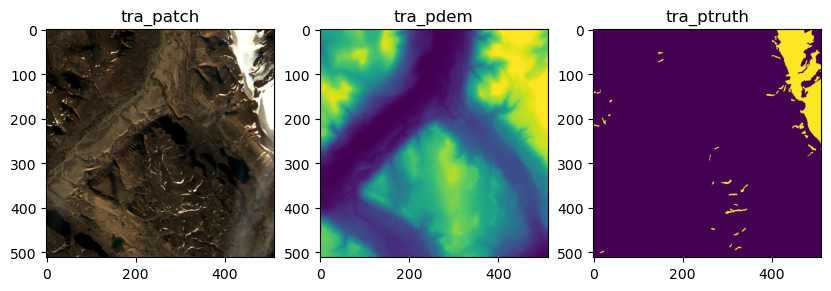

In [6]:
patch_pdem, ptruth = tra_data[0]
scene, dem = patch_pdem[:-1], patch_pdem[-1:]  ## last channel is dem
print(patch_pdem.shape, ptruth.shape)
print('training data size:',len(tra_data))
print('validation data size:', len(val_data))
imsShow([scene.numpy().astype(float).transpose((1, 2, 0)), dem.numpy().transpose((1, 2, 0)), ptruth[0].numpy()], 
              clip_list=[2,2,2], img_name_list=['tra_patch','tra_pdem','tra_ptruth'], figsize=(10, 3))


training data size: 293
validation data size: 293


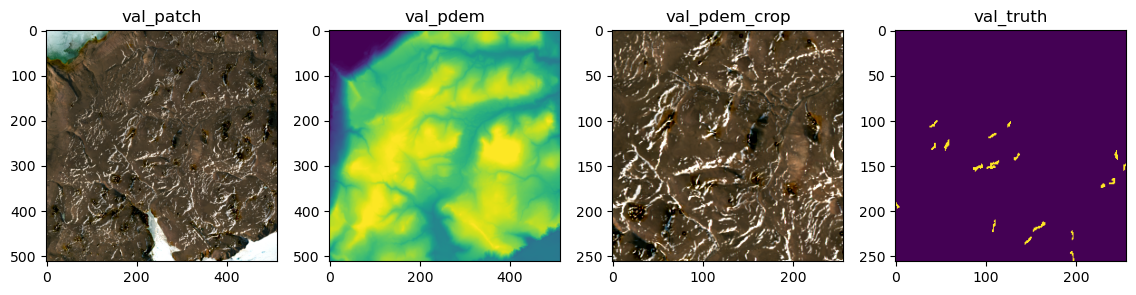

In [7]:
id = random.randint(0, len(val_data)-1)
patch_pdem, ptruth = val_data[id]
patch, pdem = patch_pdem[:6], patch_pdem[6:]

crop_start = (patch_size-256) // 2
patch_pdem_crop = patch_pdem[:, crop_start:crop_start+256, crop_start:crop_start+256]

print('training data size:',len(val_data))
print('validation data size:', len(val_data))
imsShow([patch.numpy().transpose((1,2,0)), pdem.numpy().transpose((1,2,0)), patch_pdem_crop.numpy().transpose((1,2,0)), ptruth[0].numpy()], 
              clip_list=[2,2,2,0], 
              img_name_list=['val_patch','val_pdem', 'val_pdem_crop', 'val_truth', ], 
              figsize=(14, 3))


In [34]:
### Create DataLoader
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=5)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=4,
                                         num_workers=5)


In [36]:
## check data loading time
time_start = time.time()
for x_batch, y_batch in tra_loader:
  print(f"traBatch processing time: {time.time() - time_start:.1f}")
time_start = time.time()  

# ## check data loading time
# time_start = time.time()
# for x_batch, y_batch in val_loader:
#   print(f"valBatch processing time: {time.time() - time_start:.1f}")
# time_start = time.time()   


traBatch processing time: 0.3
traBatch processing time: 0.4
traBatch processing time: 0.7
traBatch processing time: 0.7
traBatch processing time: 0.8
traBatch processing time: 0.8
traBatch processing time: 0.9
traBatch processing time: 0.9
traBatch processing time: 0.9
traBatch processing time: 0.9
traBatch processing time: 1.0
traBatch processing time: 1.4


torch.Size([4, 7, 512, 512]) torch.Size([4, 1, 512, 512])


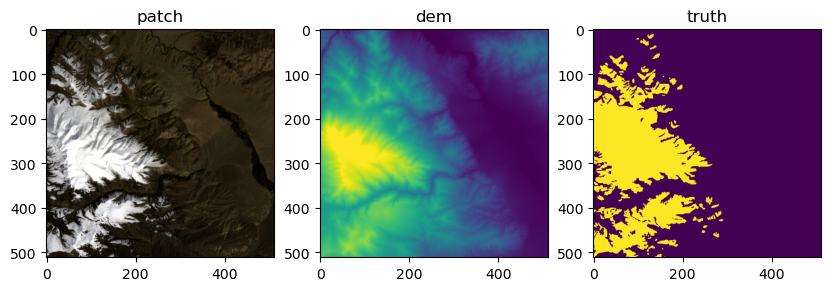

In [18]:
# for patch, truth in tra_loader:
#     print(patch.shape)
batch_patch, batch_truth = next(iter(tra_loader))
print(batch_patch.shape, batch_truth.shape)
patch_arr = batch_patch[0].numpy().transpose((1, 2, 0))
dem_arr = batch_patch[0].numpy()[-1]
truth_arr = batch_truth[0].numpy().squeeze()
imsShow([patch_arr,  dem_arr, truth_arr],  
          color_bands_list=[[2,1,0], None, None],
          img_name_list=['patch', 'dem', 'truth'], 
          clip_list=[2,2,2], 
          figsize=(10, 3))
